# Exercises

This notebook contains exercises for section 2.3 of the Medford group graduate student training. These exercises cover DFT applications.

## Exercise 1

One major application of density functional theory is performing structural relaxation (i.e., geometric optimization). <br> Begin by building a linear CO<sub>2</sub> molecule in ASE with a C–O bond length of 1.8 Å.

In [9]:
from ase import Atoms

CO2 = Atoms('OCO', positions=[(0, 0, 0), (1.8, 0, 0), (3.6, 0,0)], pbc=True)
CO2.center(vacuum=5)

Next, relax your molecule using SPARC with parameters of your choosing. Confirm that your relaxed C–O bond length matches that from experimentation.

In [57]:
import os
from sparc import SPARC
from ase.units import Bohr,Hartree,mol,kcal,kJ,eV
from ase.io import read, write


parameters = dict(
                EXCHANGE_CORRELATION = 'GGA_PBE',
                D3_FLAG=1,   #Grimme D3 dispersion correction
                SPIN_TYP=0,   #spin-polarized calculation
                KPOINT_GRID=[1,1,1],  
                ECUT=800/Hartree,   #set ECUT (Hartree) or h (Angstrom)
                #h = 0.15,
                TOL_SCF=1e-4,
                RELAX_FLAG=1,
                TOL_RELAX = 5.00E-04,  #convergence criteria (maximum force) (Ha/Bohr)
                PRINT_FORCES=1,
                PRINT_RELAXOUT=1)

cwd = os.getcwd()
parameters['directory'] = cwd + '/Exercise_1'
atoms = CO2.copy()
calc = SPARC(atoms = atoms, **parameters)
atoms.set_calculator(calc)

#atoms.write('Exercise_1/POSCAR_1')
eng_CO2 = atoms.get_potential_energy()
atoms.write('Exercise_1/CONTCAR_1')

CO2 = atoms

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Step  6
Step  7
Step  8
Step  9
{}
[1, 0, 2] [1, 0, 2]


In [58]:
d = CO2.get_distances(0,1)[0]
print(f"Calculated C=O bond distance is {d:.3f} Ang, which is very similar to the experimental value of 1.162 Ang.")
#https://cccbdb.nist.gov/expgeom2.asp?casno=124389&charge=0

Calculated C=O bond distance is 1.171 Ang, which is very similar to the experimental value of 1.162 Ang.


Repeat this exercise using the Quantum Espresso DFT package.

In [71]:
# code here

## Exercise 2

In this exercise, we will consider the adsorption of an atomic oxygen on Pt(111) surface, instead of O<sub>2</sub> molecule.
Determine the most stable adsorption site of an oxygen atom on Pt(111) surface and the corresponding adsorption energy when the surface is saturated with one monolayer of oxygens (in this case, one O atom for each Pt surface atom).

In [107]:
from ase import Atoms, Atom
from ase.build import bulk, molecule, surface, add_adsorbate, fcc111, fcc100
from ase.constraints import FixAtoms
from ase.io import read

 ### Pristine slab
slab = fcc111('Pt', size=(1,1,3), vacuum=7)

c = FixAtoms (indices = [ atom.index for atom in slab if atom.scaled_position[2] <0.51 ]) #constrained atoms (fixing the bottom 2 layers)
slab.set_constraint(c)

 ### Slab with O adsorbate (fcc)
slab_ads_fcc = slab.copy()
adsorbate = molecule('O')
add_adsorbate(slab_ads_fcc, adsorbate, height = 2.5, position = 'fcc' )

 ### Slab with O adsorbate (hcp)
slab_ads_hcp = slab.copy()
adsorbate = molecule('O')
add_adsorbate(slab_ads_hcp, adsorbate, height = 2.5, position = 'hcp' )

 ### O2 molecule
O2 = molecule('O2')
O2.set_cell(np.array([10, 10, 10]))
O2.center()


In [108]:
atoms_dict = {'slab':slab, 'slab_ads_fcc':slab_ads_fcc, 'slab_ads_hcp':slab_ads_hcp, 'O2':O2}
E_dict = {}

for key in atoms_dict:
    
    atoms = atoms_dict[key]
    
    parameters = dict(
                    EXCHANGE_CORRELATION = 'GGA_PBE',
                    D3_FLAG=1,   #Grimme D3 dispersion correction
                    SPIN_TYP=1,   #spin-polarized calculation
                    KPOINT_GRID=[4,4,1],  
                    ECUT=800/Hartree,   #set ECUT (Hartree) or h (Angstrom)
                    #h = 0.15,
                    TOL_SCF=1e-4,
                    RELAX_FLAG=1,
                    TOL_RELAX = 5.00E-04,  #convergence criteria (maximum force) (Ha/Bohr)
                    PRINT_FORCES=1,
                    PRINT_RELAXOUT=1)
    
    dir_i = f"Exercise_2/{key}"
    parameters['directory'] = dir_i
    
    if os.path.isdir(dir_i):
        print(f"{dir_i} already exists.")
        continue
    
    if key == 'O2':
        parameters['KPOINT_GRID'] = [1,1,1]
    
    calc = SPARC(atoms = atoms, **parameters)
    atoms.set_calculator(calc)

    eng = atoms.get_potential_energy()
    atoms.write(f"Exercise_2/CONTCAR_{key}")

    E_dict[key] = eng
    with open(f'{dir_i}/energy.txt', 'w') as f:
        f.write(str(eng))
    

Exercise_2/slab already exists.
Exercise_2/slab_ads_fcc already exists.
Exercise_2/slab_ads_hcp already exists.
Step  0
Step  1
Step  2
Step  3
Step  4
{}
[0, 1] [0, 1]


In [126]:
def readFile(path):
    f = open(path, 'r')
    content = f.readlines()
    return content

def read_energy(path):
    energy = float(readFile(path)[0])
    return energy

#E_dict = {}
for key in atoms_dict:
    dir_i = f'Exercise_2/{key}'
    E_dict[key] = read_energy(f'{dir_i}/energy.txt')
    
print(f"O adsorption on fcc: {E_dict['slab_ads_fcc'] - E_dict['slab'] - 0.5*E_dict['O2']:.3f}")
print(f"O adsorption on hcp: {E_dict['slab_ads_hcp'] - E_dict['slab'] - 0.5*E_dict['O2']:.3f}")
print('The fcc site is preferred for O adsorption.')

O adsorption on fcc: -0.241
O adsorption on hcp: 0.221
The fcc site is preferred for O adsorption.


## Exercise 3

In this exercise, we revisit Ca-LTA one final time. CO<sub>2</sub> can adsorb in Ca-LTA in one of three positions shown in the figure below. Note that the large teal atoms are calcium.

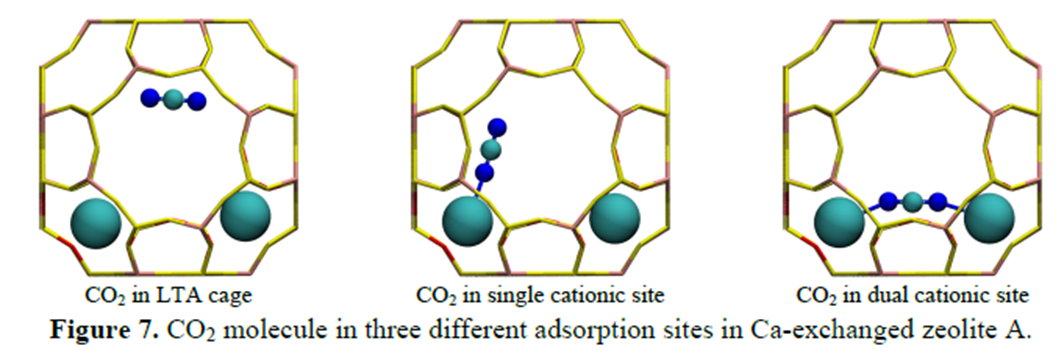

Using a DFT package and calculation parameters of your choice, compute the CO<sub>2</sub> adsorption energy for each of the three positions in Ca-LTA. *This exercise requires that you manually add CO<sub>2</sub> molecules into the Ca-LTA framework and that you perform several structural relaxations at different geometries. You can fix the atomic positions of Ca-LTA to reduce the computational cost*

In [59]:
# First, relax the pristine MOF

import os
from ase import Atoms, io
from ase.io import read, write
from ase.build import bulk, molecule, surface, add_adsorbate
from ase.units import Bohr,Hartree,mol,kcal,kJ,eV
from ase.constraints import FixAtoms
from sparc import SPARC

parameters = dict(
                EXCHANGE_CORRELATION = 'GGA_PBE',
                D3_FLAG=1,   #Grimme D3 dispersion correction
                SPIN_TYP=0,   #spin-polarized calculation
                KPOINT_GRID=[1,1,1],  
                ECUT=600/Hartree,   #set ECUT (Hartree) or h (Angstrom)
                #h = 0.15,
                TOL_SCF=1e-4,
                RELAX_FLAG=1,
                TOL_RELAX = 2.00E-03,  #convergence criteria (maximum force) (Ha/Bohr)
                PRINT_FORCES=1,
                PRINT_RELAXOUT=1)

cwd = os.getcwd()
parameters['directory'] = cwd + '/Exercise_3/pristine'

atoms = read('CaLTA.vasp')
c = FixAtoms (indices = [atom.index for atom in atoms])
atoms.set_constraint(c)

calc = SPARC(atoms = atoms, **parameters)
atoms.set_calculator(calc)

eng_pristine = atoms.get_potential_energy()
atoms.write('Exercise_3/CONTCAR_3_pristine')
eng_pristine

Step  0
{0: array([False, False, False]), 1: array([False, False, False]), 2: array([False, False, False]), 3: array([False, False, False]), 4: array([False, False, False]), 5: array([False, False, False]), 6: array([False, False, False]), 7: array([False, False, False]), 8: array([False, False, False]), 9: array([False, False, False]), 10: array([False, False, False]), 11: array([False, False, False]), 12: array([False, False, False]), 13: array([False, False, False]), 14: array([False, False, False]), 15: array([False, False, False]), 16: array([False, False, False]), 17: array([False, False, False]), 18: array([False, False, False]), 19: array([False, False, False]), 20: array([False, False, False]), 21: array([False, False, False]), 22: array([False, False, False]), 23: array([False, False, False]), 24: array([False, False, False]), 25: array([False, False, False]), 26: array([False, False, False]), 27: array([False, False, False]), 28: array([False, False, False]), 29: array([Fals

-26357.73922193604

In [64]:
# code here - LTA cage configuration
from sparc import SPARC
from ase import Atom
from ase.build import bulk, molecule, surface, add_adsorbate
from ase.units import Bohr,Hartree,mol,kcal,kJ,eV
from ase.io import read, write
import numpy as np

atoms = read('CaLTA.vasp')
c = FixAtoms (indices = [atom.index for atom in atoms])
atoms.set_constraint(c)

CO2_original = CO2.copy()
CO2.cell = atoms.cell
CO2.center()
CO2.translate([0,0,2])
atoms.extend(CO2)

atoms.write('Exercise_3/POSCAR_3_LTA')
#CO2.write('POSCAR_CO2')

In [65]:
parameters['directory'] = cwd + '/Exercise_3/LTA'

calc = SPARC(atoms = atoms, **parameters)
atoms.set_calculator(calc)

eng_LTA = atoms.get_potential_energy()
atoms.write('Exercise_3/CONTCAR_3_LTA')
eng_LTA

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Step  6
Step  7
Step  8
Step  9
Step  10
{0: array([False, False, False]), 1: array([False, False, False]), 2: array([False, False, False]), 3: array([False, False, False]), 4: array([ True,  True,  True]), 5: array([False, False, False]), 6: array([False, False, False]), 7: array([False, False, False]), 8: array([False, False, False]), 9: array([False, False, False]), 10: array([False, False, False]), 11: array([False, False, False]), 12: array([False, False, False]), 13: array([False, False, False]), 14: array([False, False, False]), 15: array([False, False, False]), 16: array([False, False, False]), 17: array([False, False, False]), 18: array([False, False, False]), 19: array([False, False, False]), 20: array([False, False, False]), 21: array([False, False, False]), 22: array([False, False, False]), 23: array([False, False, False]), 24: array([ True,  True,  True]), 25: array([False, False, False]), 26: array([False, False, False]), 27

-27421.512197860437

In [66]:
# code here - single site configuration
atoms = read('CaLTA.vasp')
c = FixAtoms (indices = [atom.index for atom in atoms])
atoms.set_constraint(c)

CO2 = CO2_original.copy()
CO2.cell = atoms.cell
CO2.rotate(-45, 'y', 'COM')
d_trans = atoms[73].position - CO2[0].position + np.array([1,1,2])
CO2.translate(d_trans)
atoms.extend(CO2)

atoms.write('Exercise_3/POSCAR_3_SS')

In [67]:
parameters['directory'] = cwd + '/Exercise_3/SS'

calc = SPARC(atoms = atoms, **parameters)
atoms.set_calculator(calc)

eng_SS = atoms.get_potential_energy()
atoms.write('Exercise_3/CONTCAR_3_SS')
eng_SS

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Step  6
Step  7
Step  8
Step  9
Step  10
Step  11
Step  12
Step  13
Step  14
Step  15
Step  16
Step  17
Step  18
{0: array([False, False, False]), 1: array([False, False, False]), 2: array([False, False, False]), 3: array([False, False, False]), 4: array([ True,  True,  True]), 5: array([False, False, False]), 6: array([False, False, False]), 7: array([False, False, False]), 8: array([False, False, False]), 9: array([False, False, False]), 10: array([False, False, False]), 11: array([False, False, False]), 12: array([False, False, False]), 13: array([False, False, False]), 14: array([False, False, False]), 15: array([False, False, False]), 16: array([False, False, False]), 17: array([False, False, False]), 18: array([False, False, False]), 19: array([False, False, False]), 20: array([False, False, False]), 21: array([False, False, False]), 22: array([False, False, False]), 23: array([False, False, False]), 24: array([ True,  True,  True])

-27422.07537815338

In [68]:
# code here - dual site configuration
atoms = read('CaLTA.vasp')
c = FixAtoms (indices = [atom.index for atom in atoms])
atoms.set_constraint(c)

CO2 = CO2_original.copy()
CO2.cell = atoms.cell
d_trans = atoms[73].position - CO2[1].position + np.array([3.55,1,0])
CO2.translate(d_trans)
atoms.extend(CO2)

atoms.write('Exercise_3/POSCAR_3_DS')

In [69]:
parameters['directory'] = cwd + '/Exercise_3/DS'

calc = SPARC(atoms = atoms, **parameters)
atoms.set_calculator(calc)

eng_DS = atoms.get_potential_energy()
atoms.write('Exercise_3/CONTCAR_3_DS')
eng_DS

Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Step  6
Step  7
Step  8
Step  9
Step  10
Step  11
Step  12
Step  13
Step  14
Step  15
Step  16
Step  17
Step  18
Step  19
Step  20
Step  21
Step  22
Step  23
Step  24
Step  25
Step  26
Step  27
Step  28
Step  29
Step  30
Step  31
Step  32
Step  33
Step  34
Step  35
Step  36
Step  37
Step  38
Step  39
Step  40
Step  41
Step  42
Step  43
Step  44
Step  45
Step  46
Step  47
Step  48
Step  49
Step  50
Step  51
{0: array([False, False, False]), 1: array([False, False, False]), 2: array([False, False, False]), 3: array([False, False, False]), 4: array([ True,  True,  True]), 5: array([False, False, False]), 6: array([False, False, False]), 7: array([False, False, False]), 8: array([False, False, False]), 9: array([False, False, False]), 10: array([False, False, False]), 11: array([False, False, False]), 12: array([False, False, False]), 13: array([False, False, False]), 14: array([False, False, False]), 15: array([False, False, False]), 16: arr

-27421.778878880763

In [129]:
##### Test #####

atoms = read('Exercise_3/POSCAR_3_DS')

parameters['directory'] = cwd + '/Exercise_3/DS_spin'
parameters['SPIN_TYP'] = 1
atoms.set_initial_magnetic_moments([2.0 for atom in atoms])

calc = SPARC(atoms = atoms, **parameters)
atoms.set_calculator(calc)

eng_DS_spin = atoms.get_potential_energy()
atoms.write('Exercise_3/CONTCAR_3_DS_spin')
eng_DS_spin

srun: Job 11957 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 11957
srun: interrupt (one more within 1 sec to abort)
srun: StepId=11957.111 tasks 0-23: running


KeyboardInterrupt: 

In [130]:
print("CO2 adsorption energy:")
print(f"{eng_LTA - eng_pristine - eng_CO2:.3f} (LTA)")
print(f"{eng_SS - eng_pristine - eng_CO2:.3f} (SS)")
print(f"{eng_DS - eng_pristine - eng_CO2:.3f} (SS)")

CO2 adsorption energy:
-0.203 (LTA)
-0.767 (SS)
-0.470 (SS)
